# Extract Tables from PDF and convert to Excel sheet with Paddle OCR text detection and recognition

Source: https://www.youtube.com/watch?v=HZh31OGiQRQ

In [36]:
from pdf2image import convert_from_path

images = convert_from_path(r"khalis2019.pdf")

In [37]:
 for idx, image in enumerate(images):
        image.save(f"pages/page{idx}.jpg", "JPEG")

In [38]:
# !pip install paddleocr --upgrade
# !pip install paddlepaddle

## Layout Extraction

In [39]:
import cv2
import layoutparser as lp
image = cv2.imread("pages/page2.jpg")

image = image[..., ::-1]

# load model
model = lp.PaddleDetectionLayoutModel(config_path="lp://PubLayNet/ppyolov2_r50vd_dcn_365e_publaynet/config",
                                threshold=0.5,
                                label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"},
                                enforce_cpu=False,
                                enable_mkldnn=True)#math kernel library
# detect
layout = model.detect(image)

E0302 13:13:44.271808 76297 analysis_config.cc:110] Please use PaddlePaddle with GPU version.


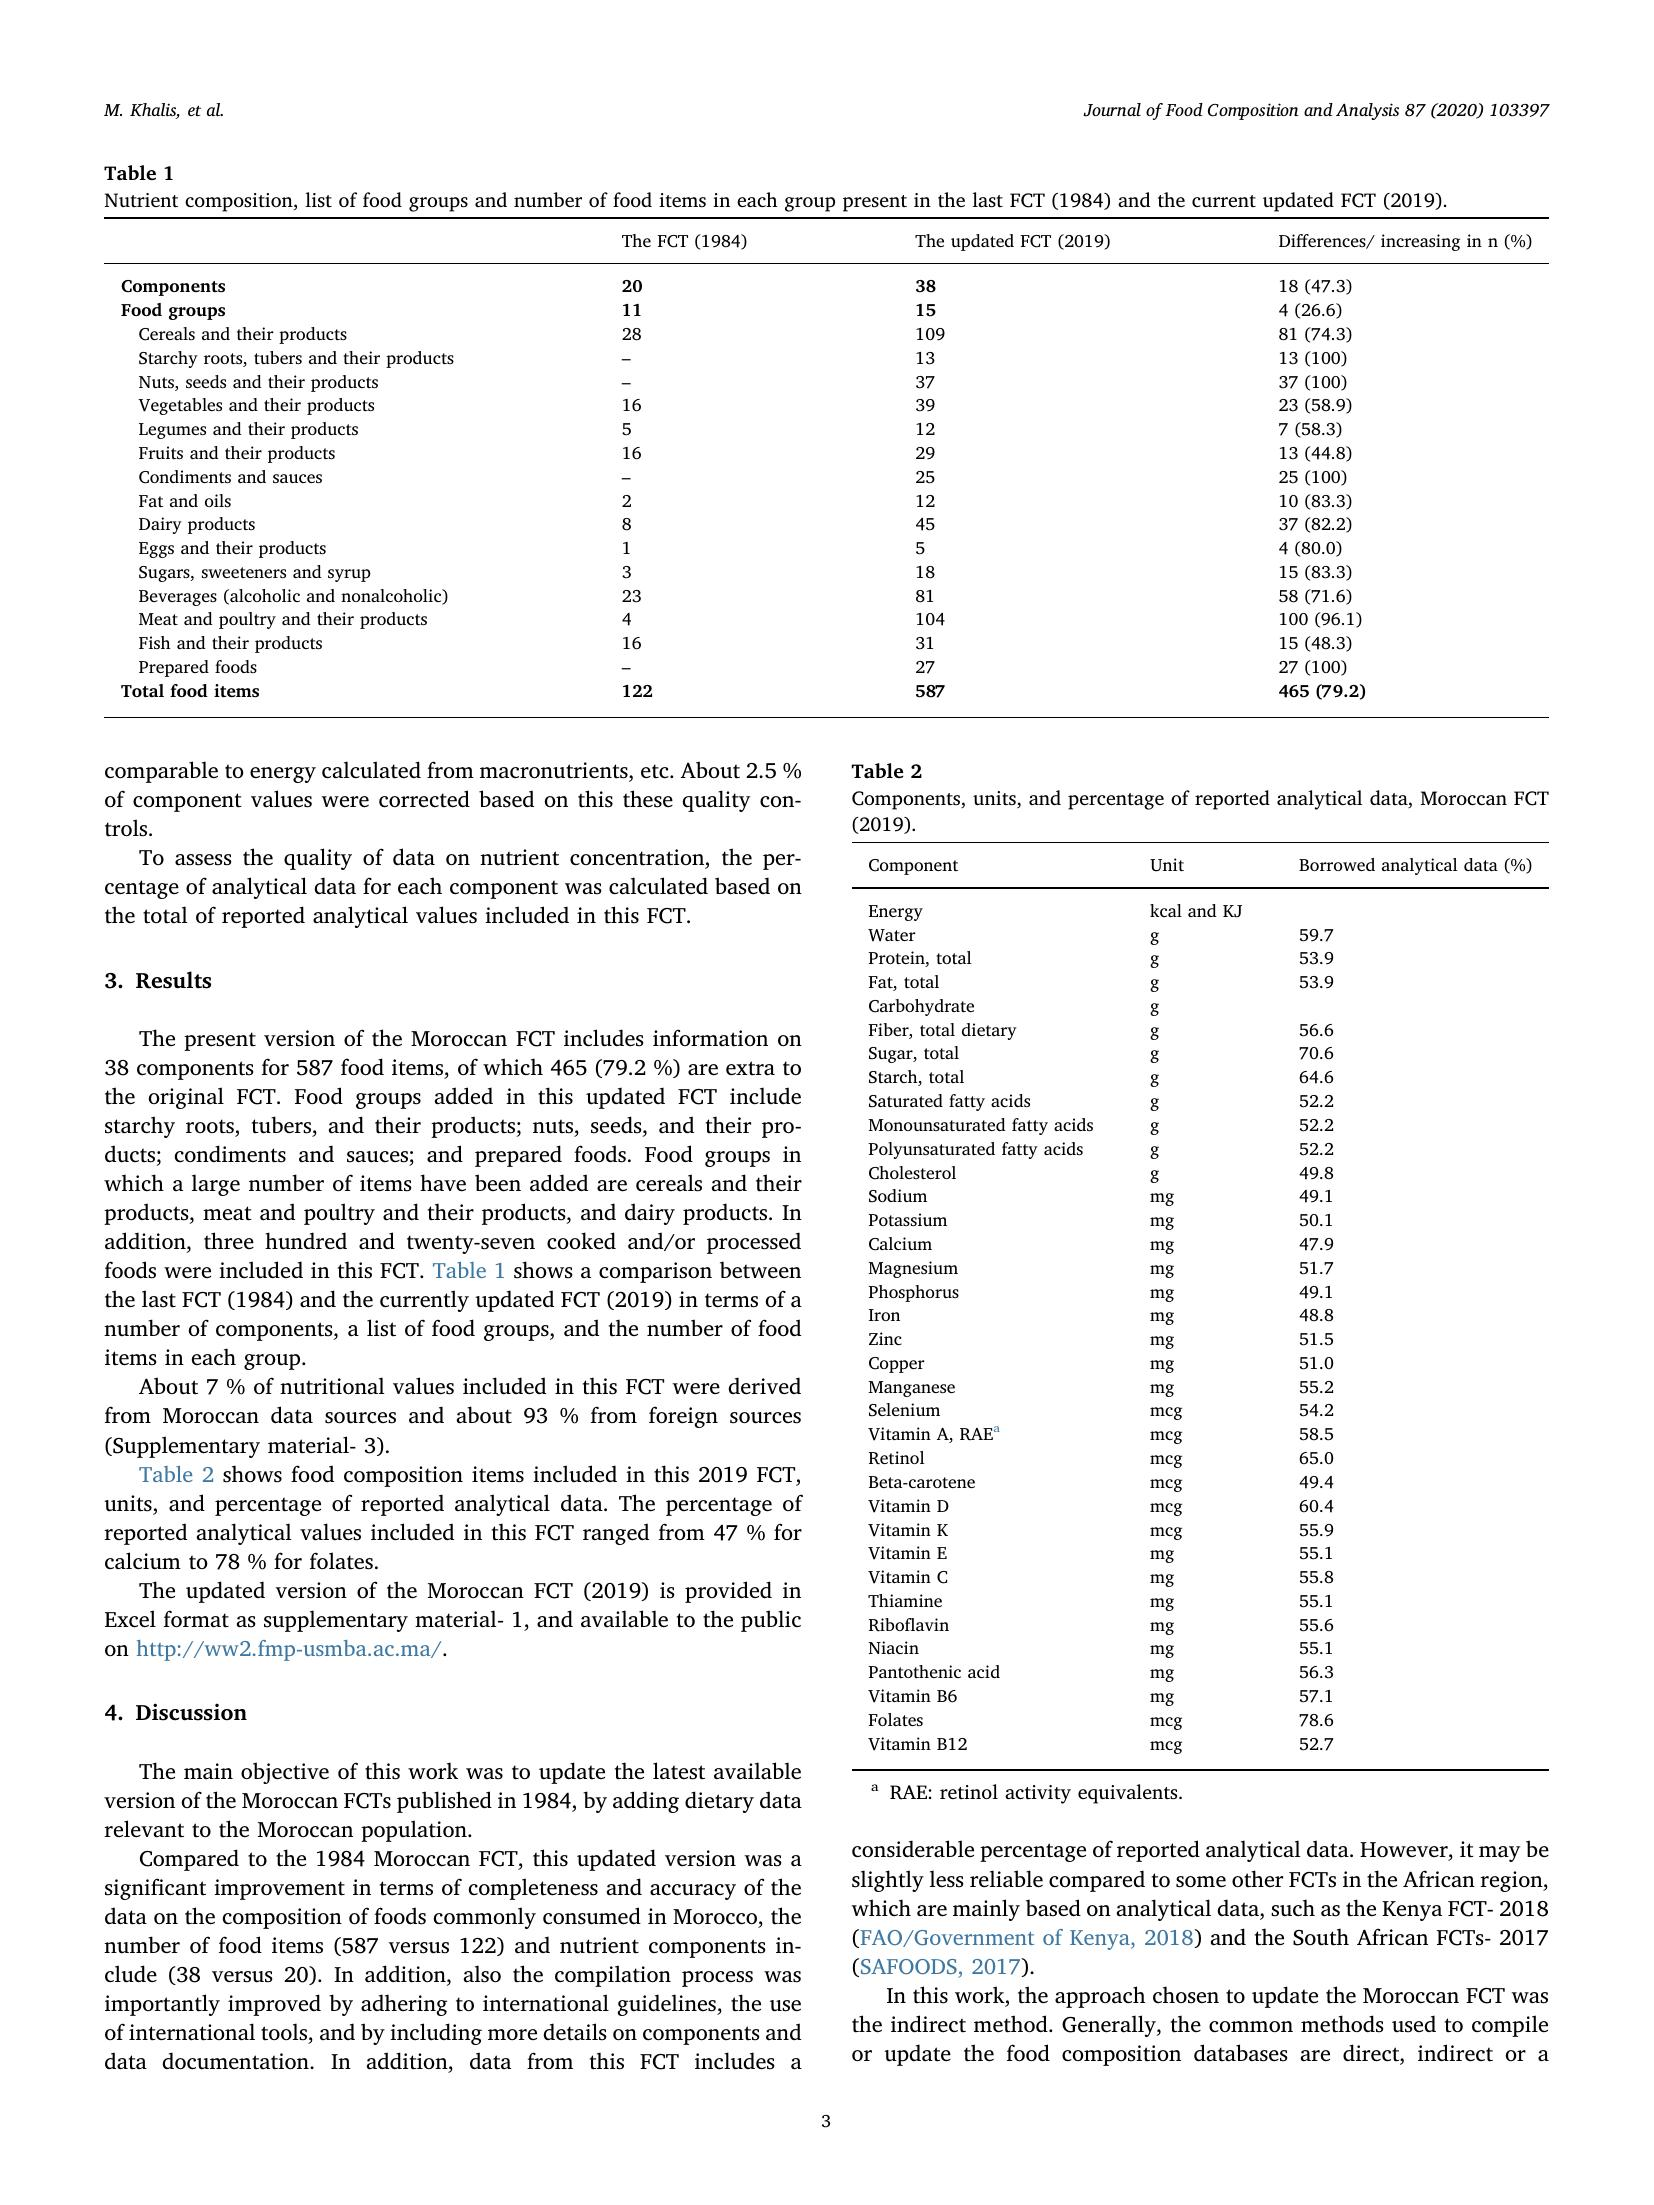

In [91]:
Image(filename="pages/page2.jpg")

In [40]:
x_1=0
y_1=0
x_2=0
y_2=0

for l in layout:
  #print(l)
  if l.type == 'Table':
    x_1 = int(l.block.x_1)
    print(l.block.x_1)
    y_1 = int(l.block.y_1)
    x_2 = int(l.block.x_2)
    y_2 = int(l.block.y_2)
    
    break

852.8346


In [41]:
print(x_1,y_1,x_2,y_2)

852 844 1550 1766


In [42]:
image = cv2.imread("pages/page2.jpg")
cv2.imwrite("extracted_table.jpg", image[y_1:y_2,x_1:x_2])

True

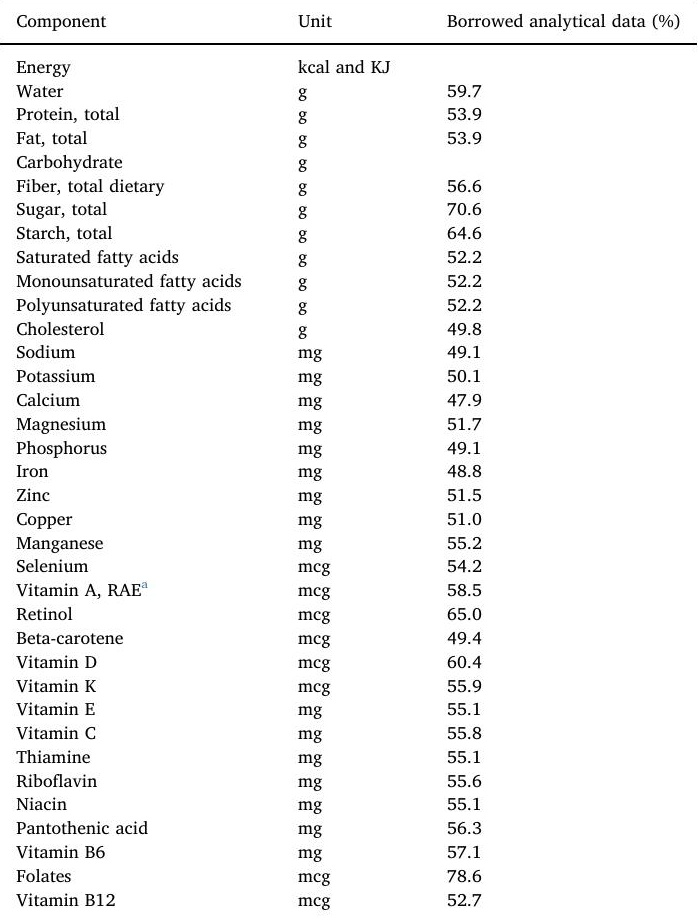

In [43]:
from IPython.display import Image
Image(filename='extracted_table.jpg') 

## Text Detection and Recognition

In [44]:
from paddleocr import PaddleOCR, draw_ocr

ocr = PaddleOCR(lang="en")

[2023/03/02 13:13:50] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/milan/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/milan/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path

In [45]:
image_path = "extracted_table.jpg"
image_cv = cv2.imread(image_path)
image_height = image_cv.shape[0]
image_width = image_cv.shape[1]

output = ocr.ocr(image_path)
# print(output)

[2023/03/02 13:13:50] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/03/02 13:13:52] ppocr DEBUG: dt_boxes num : 109, elapse : 1.2217092514038086
[2023/03/02 13:14:00] ppocr DEBUG: rec_res num  : 109, elapse : 8.611942768096924


In [46]:
 output[0][0]

[[[16.0, 13.0], [107.0, 13.0], [107.0, 31.0], [16.0, 31.0]],
 ('Component', 0.9982334971427917)]

In [47]:
coords = ocr_word[0]
x1, y1 = coords[0][0], coords[0][1]
x1

445.0

In [48]:
ocr_word[1]

('52.7', 0.9971269965171814)

In [49]:
result = image_cv.copy()
for ocr_word in output[0]:
    coords = ocr_word[0]
    text = ocr_word[1][0]
    x1, y1 = int(coords[0][0]), int(coords[0][1])
    x2, y2 = int(coords[2][0]), int(coords[2][1])
    cv2.rectangle(result, (x1, y1), (x2, y2), (0, 0, 255), 1)
    cv2.putText(result, text, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, .45, (222, 0, 0), 1)
    
cv2.imwrite('ocr_bboxes.jpg',result)

True

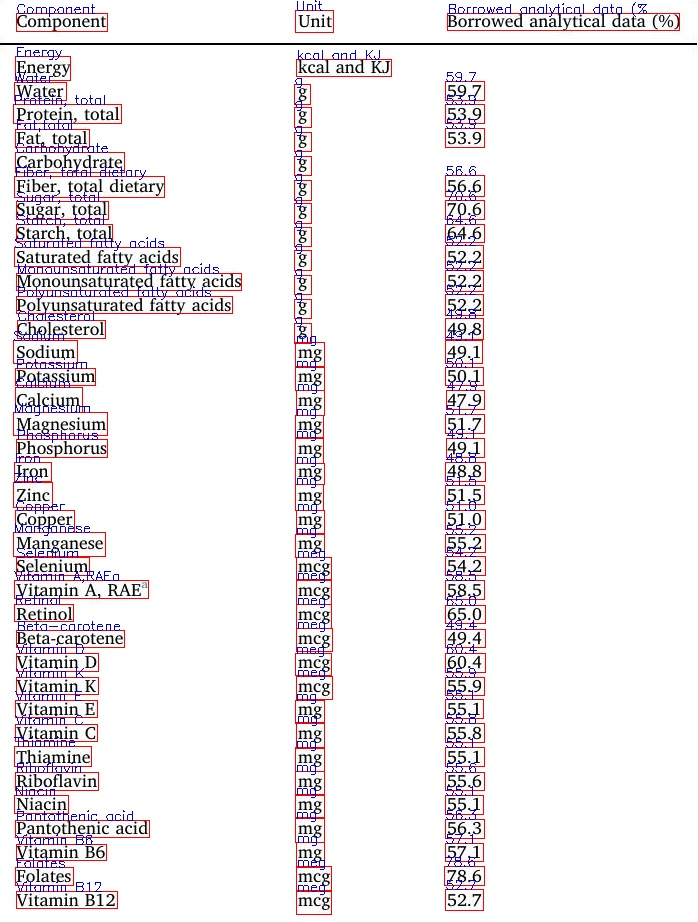

In [50]:
from IPython.display import Image
Image(filename='ocr_bboxes.jpg') 

## Text Reconstruction

In [51]:
boxes = [line[0] for line in output[0]]
texts = [line[1][0] for line in output[0]]
probabilities = [line[1][1] for line in output[0]]

In [52]:
image_boxes = image_cv.copy()

horizontal_boxes = []
vertical_boxes = []

for box in boxes:
    x_h, x_v = 0,int(box[0][0])
    y_h, y_v = int(box[0][1]), 0
    width_h, width_v = image_width, int(box[2][0]-box[0][0])
    height_h, height_v = int(box[2][1]-box[0][1]),image_height

    horizontal_boxes.append([x_h,y_h,x_h+width_h,y_h+height_h])
    vertical_boxes.append([x_v,y_v,x_v+width_v,y_v+height_v])

    cv2.rectangle(image_boxes,(x_h,y_h), (x_h+width_h,y_h+height_h),(0,0,255),1)
    cv2.rectangle(image_boxes,(x_v,y_v), (x_v+width_v,y_v+height_v),(0,255,0),1)

In [53]:
cv2.imwrite('detections.jpg', image_boxes)

True

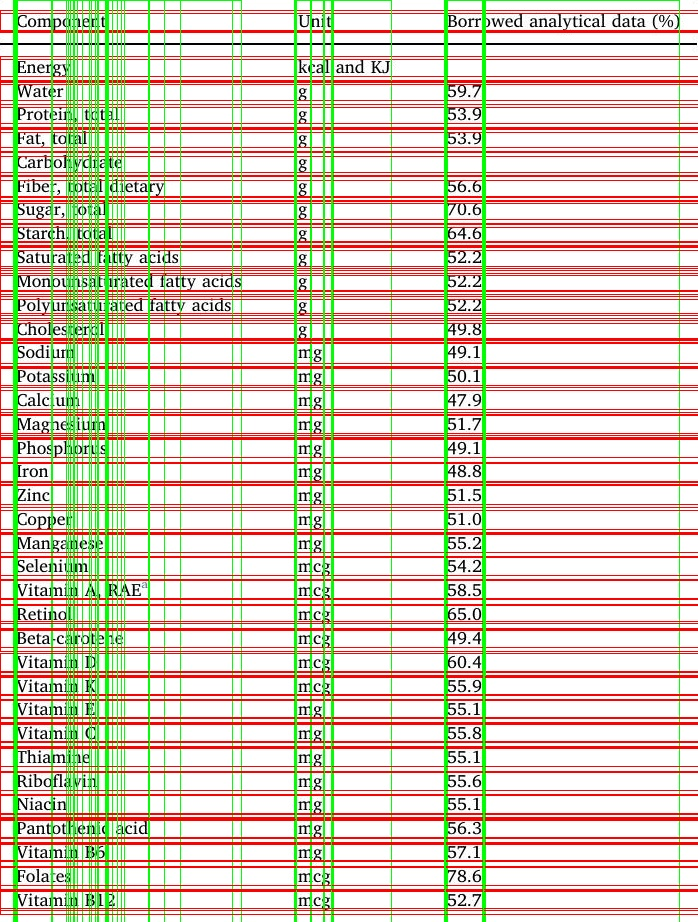

In [54]:
Image(filename="detections.jpg")

## Non-Max Suppression

In [55]:
import tensorflow as tf

In [56]:
horiz_out = tf.image.non_max_suppression(
    horizontal_boxes,
    probabilities,
    max_output_size = 1000,
    iou_threshold=0.1,
    score_threshold=float('-inf'),
    name=None
)

In [57]:
import numpy as np

horiz_lines = np.sort(np.array(horiz_out))
print(horiz_lines)

[  0   3   5  10  13  14  18  21  24  27  30  33  36  37  40  45  46  51
  52  57  58  61  64  69  72  75  78  81  84  87  88  93  94  99 101 105
 108]


In [58]:
im_nms = image_cv.copy()

In [59]:
for val in horiz_lines:
  cv2.rectangle(
      im_nms,
      (int(horizontal_boxes[val][0]),int(horizontal_boxes[val][1])),
      (int(horizontal_boxes[val][2]),int(horizontal_boxes[val][3])),
      (0,0,255),
      1
  )
cv2.imwrite('im_nms.jpg',im_nms)

True

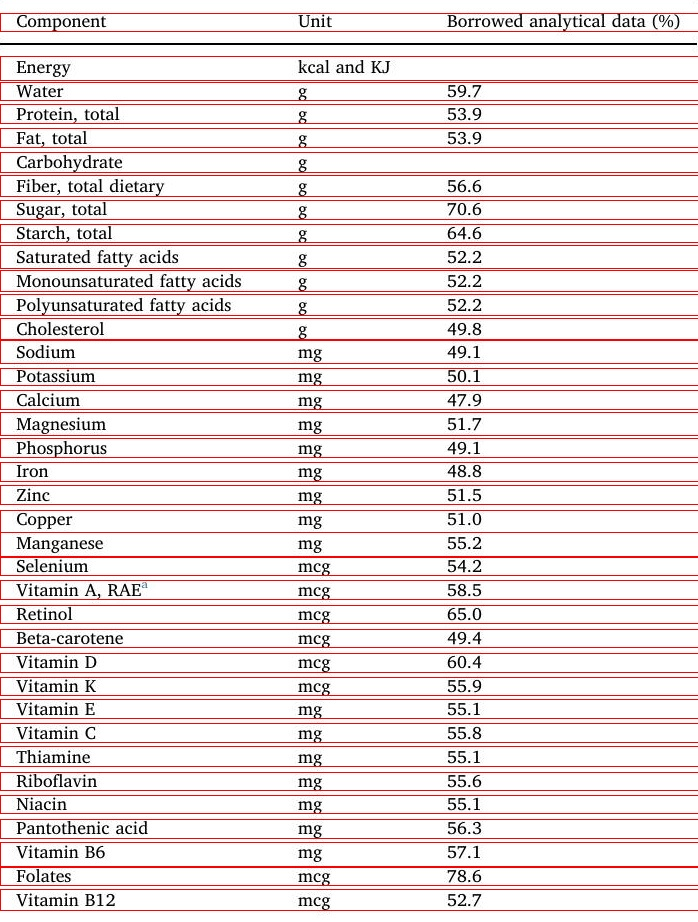

In [60]:
Image(filename=r"im_nms.jpg")

In [61]:
vert_out = tf.image.non_max_suppression(
    vertical_boxes,
    probabilities,
    max_output_size = 1000,
    iou_threshold=0.1,
    score_threshold=float('-inf'),
    name=None
)
print(vert_out)

tf.Tensor([52 45 95], shape=(3,), dtype=int32)


In [62]:
vert_lines = np.sort(np.array(vert_out))
print(vert_lines)

[45 52 95]


In [63]:
for val in vert_lines:
  cv2.rectangle(
      im_nms,
      (int(vertical_boxes[val][0]),int(vertical_boxes[val][1])),
      (int(vertical_boxes[val][2]),int(vertical_boxes[val][3])),
      (255,0,0),
      1
  )
cv2.imwrite('im_nms.jpg',im_nms)

True

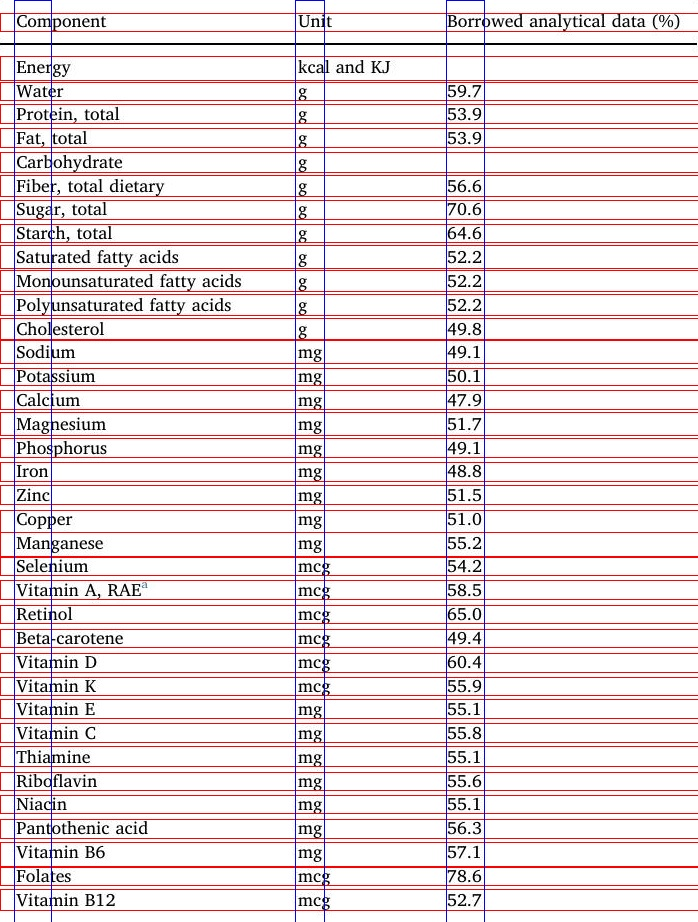

In [64]:
Image(filename="im_nms.jpg")

## Convert to CSV

In [65]:
out_array = [["" for i in range(len(vert_lines))] for j in range(len(horiz_lines))]
print(np.array(out_array).shape)
print(out_array)

(37, 3)
[['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', ''], ['', '', '']]


In [66]:
unordered_boxes = []

for i in vert_lines:
  print(vertical_boxes[i])
  unordered_boxes.append(vertical_boxes[i][0])

[446, 0, 484, 922]
[14, 0, 51, 922]
[295, 0, 324, 922]


In [67]:
ordered_boxes = np.argsort(unordered_boxes)
print(ordered_boxes)

[1 2 0]


In [68]:
def intersection(box_1, box_2):
  return [box_2[0], box_1[1],box_2[2], box_1[3]]

In [69]:
def iou(box_1, box_2):

  x_1 = max(box_1[0], box_2[0])
  y_1 = max(box_1[1], box_2[1])
  x_2 = min(box_1[2], box_2[2])
  y_2 = min(box_1[3], box_2[3])

  inter = abs(max((x_2 - x_1, 0)) * max((y_2 - y_1), 0))
  if inter == 0:
      return 0
      
  box_1_area = abs((box_1[2] - box_1[0]) * (box_1[3] - box_1[1]))
  box_2_area = abs((box_2[2] - box_2[0]) * (box_2[3] - box_2[1]))
  
  return inter / float(box_1_area + box_2_area - inter)

In [71]:
for i in range(len(horiz_lines)):
  for j in range(len(vert_lines)):
    resultant = intersection(horizontal_boxes[horiz_lines[i]], vertical_boxes[vert_lines[ordered_boxes[j]]] )

    for b in range(len(boxes)):
      the_box = [boxes[b][0][0],boxes[b][0][1],boxes[b][2][0],boxes[b][2][1]]
      if(iou(resultant,the_box)>0.1):
        out_array[i][j] = texts[b]

In [73]:
out_array=np.array(out_array)
out_array

array([['Component', 'Unit', 'Borrowed analytical data (%'],
       ['Energy', 'kcal and KJ', ''],
       ['Water', 'g', '59.7'],
       ['Protein, total', 'g', '53.9'],
       ['Fat,total', 'g', '53.9'],
       ['Carbohydrate', 'g', ''],
       ['Fiber, total dietary', 'g', '56.6'],
       ['Sugar, total', 'g', '70.6'],
       ['Starch, total', 'g', '64.6'],
       ['Saturated fatty acids', 'g', '52.2'],
       ['Monounsaturated fatty acids', 'g', '52.2'],
       ['Polyunsaturated fatty acids', 'g', '52.2'],
       ['Cholesterol', 'g', '49.8'],
       ['Sodium', 'mg', '49.1'],
       ['Potassium', 'mg', '50.1'],
       ['Calcium', 'mg', '47.9'],
       ['Magnesium', 'mg', '51.7'],
       ['Phosphorus', 'mg', '49.1'],
       ['Iron', 'mg', '48.8'],
       ['Zinc', 'mg', '51.5'],
       ['Copper', 'mg', '51.0'],
       ['Manganese', 'mg', '55.2'],
       ['Selenium', 'meg', '54.2'],
       ['Vitamin A,RAEa', 'meg', '58.5'],
       ['Retinol', 'meg', '65.0'],
       ['Beta-carotene', 'me

In [75]:
import pandas as pd

pd.DataFrame(out_array).to_csv('sample.csv')

## Merging Cells

In [76]:
current_bank=['']*len(out_array[0,:])
print(current_bank)

['', '', '']


In [77]:
def empty(arr):
  for i in arr:
    if i=='':
      return True
  return False

In [79]:
cleaned_array=[]

for i in range(len(out_array)):
  if not empty(out_array[i]):
    current_bank=[out_array[i][j] for j in range(len(out_array[i]))]
    cleaned_array.append(current_bank)
    not_empty=True
  else:
    for j in range(len(out_array[i])):
      current_bank[j]+=' '+out_array[i][j]
    print('-->',current_bank)
cleaned_array=np.array(cleaned_array)
print(cleaned_array)

--> ['Component Energy', 'Unit kcal and KJ', 'Borrowed analytical data (% ']
--> ['Fat,total Carbohydrate', 'g g', '53.9 ']
[['Component Energy' 'Unit kcal and KJ' 'Borrowed analytical data (% ']
 ['Water' 'g' '59.7']
 ['Protein, total' 'g' '53.9']
 ['Fat,total Carbohydrate' 'g g' '53.9 ']
 ['Fiber, total dietary' 'g' '56.6']
 ['Sugar, total' 'g' '70.6']
 ['Starch, total' 'g' '64.6']
 ['Saturated fatty acids' 'g' '52.2']
 ['Monounsaturated fatty acids' 'g' '52.2']
 ['Polyunsaturated fatty acids' 'g' '52.2']
 ['Cholesterol' 'g' '49.8']
 ['Sodium' 'mg' '49.1']
 ['Potassium' 'mg' '50.1']
 ['Calcium' 'mg' '47.9']
 ['Magnesium' 'mg' '51.7']
 ['Phosphorus' 'mg' '49.1']
 ['Iron' 'mg' '48.8']
 ['Zinc' 'mg' '51.5']
 ['Copper' 'mg' '51.0']
 ['Manganese' 'mg' '55.2']
 ['Selenium' 'meg' '54.2']
 ['Vitamin A,RAEa' 'meg' '58.5']
 ['Retinol' 'meg' '65.0']
 ['Beta-carotene' 'meg' '49.4']
 ['Vitamin D' 'meg' '60.4']
 ['Vitamin K' 'meg' '55.9']
 ['Vitamin E' 'mg' '55.1']
 ['Vitamin C' 'mg' '55.8']
 ['Th

In [80]:
pd.DataFrame(cleaned_array).to_csv('cleaned.csv')

## CSV to Text

In [84]:
import  jpype     
import  asposecells  

jpype.startJVM() 
from asposecells.api import Workbook

workbook = Workbook("sample.csv")
workbook.save("Output.docx")
jpype.shutdownJVM()

## Brighten Image (For Anyone dealing with PDFs created from scanned images)

In [86]:
from PIL import Image, ImageEnhance

#read the image
im = Image.open("extracted_table.jpg")

#image brightness enhancer
enhancer = ImageEnhance.Brightness(im)

factor = 1 #gives original image
im_output = enhancer.enhance(factor)
im_output.save('extracted_table-1.jpg')

factor = 1.5## brightens the image
im_output = enhancer.enhance(factor)
im_output.save('extracted_table-2.jpg')


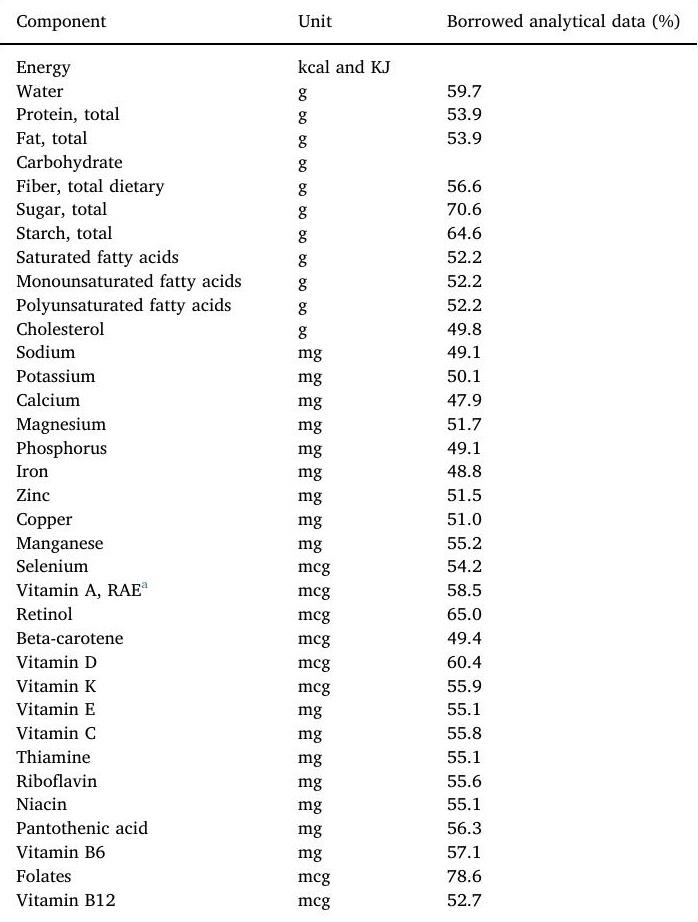

In [88]:
from IPython.display import Image
Image(filename='extracted_table-1.jpg') 

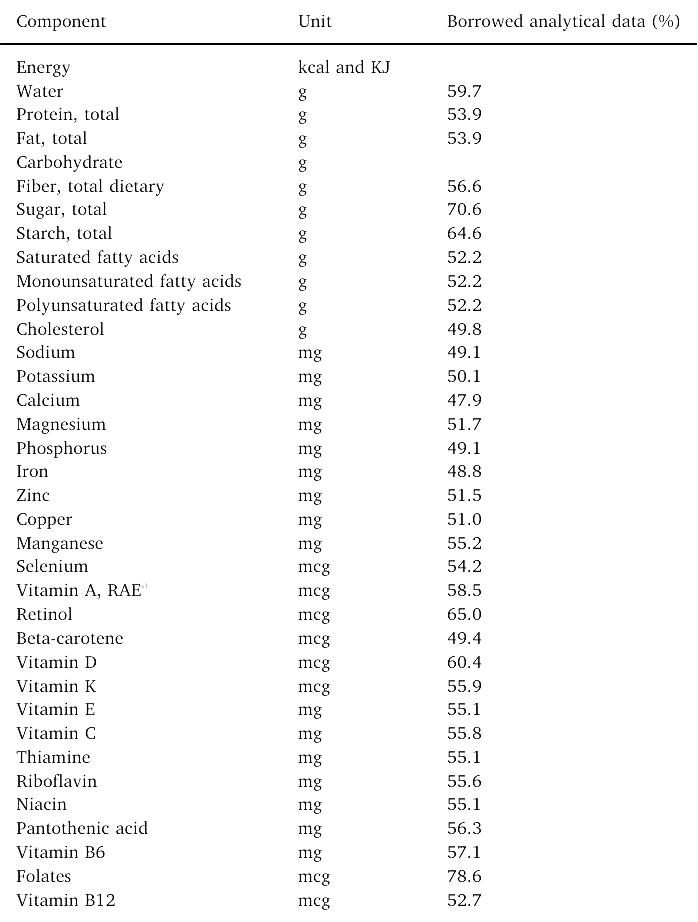

In [89]:
from IPython.display import Image
Image(filename='extracted_table-2.jpg') 

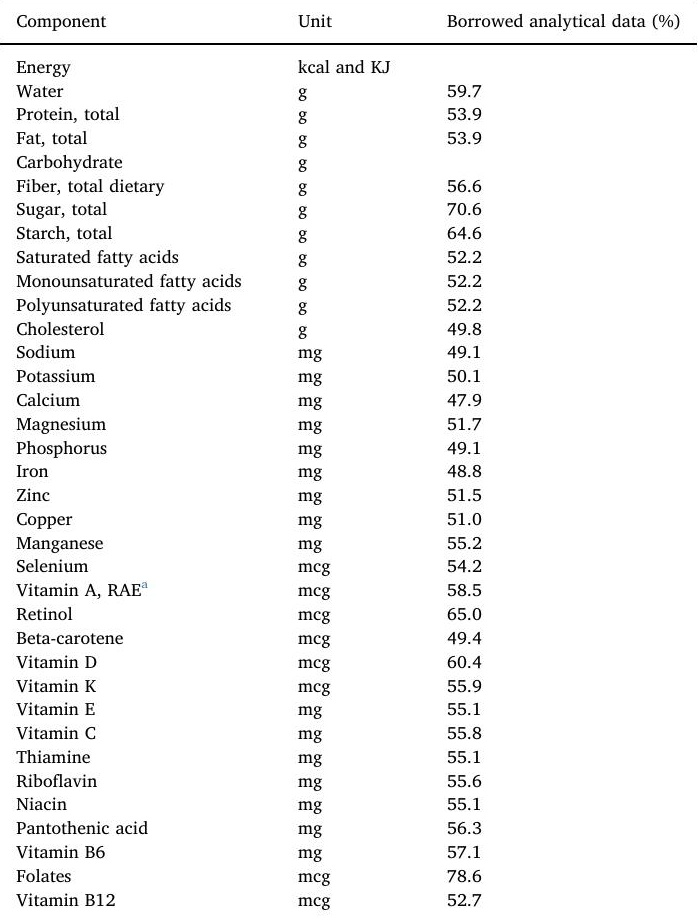

In [90]:
from IPython.display import Image
Image(filename='extracted_table.jpg') 